**Tech stack:**


*   Tensorflow



In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
# can also use adam optimizer for descent later

from tensorflow.keras.models import load_model
from tensorflow_addons.optimizers import MultiOptimizer

import os
import random
from joblib import load, dump
import gc
import sys
from math import ceil

tf.keras.backend.set_floatx('float32')
# input_shape = (128, 128, 3)

In [ ]:
"""
the base predictor model is loaded here, there is an option of 4 models
1. load_model('models/scratch_age.h5')
2. load_model('models/pretrain_gender.h5')
3. load_model('models/pretrain_age.h5')
4. tf.keras.applications.mobilenet_v2.MobileNetV2()
"""

base_model = load_model('models/pretrain_gender.h5')

In [ ]:
# a sketch of the model architecture is displayed
base_model.summary()

In [ ]:
# layer you choose to run gradients on (y). Doesn't necessarily have to be the output layer
name = 'predictions'

layer = base_model.get_layer(name).output

In [ ]:
adverse_model = tf.keras.Model(inputs=base_model.input, outputs=layer)

In [ ]:
"""
in the case that the chosen layer for loss calculation is not the final output layer,
a target image is generally used to calculate the desired 'y' for the chosen layer
however in the case of the the loss being minimized for the output layer, human-interpretable targets can be used
i.e. setting the model output to the desired age, class etc.
"""

original_img = tf.keras.preprocessing.image.load_img('cat.jpg', target_size=(224, 224))
original_img = tf.keras.applications.inception_v3.preprocess_input(np.array(original_img))

target_img = tf.keras.preprocessing.image.load_img('tiger.jpg', target_size=(224, 224))
target_img = tf.keras.applications.inception_v3.preprocess_input(np.array(target_img))

In [ ]:
# these functions were just used as a tool during my project to visualise the hidden activations of the model
def get_activations(image):
    layer_outputs = [layer.output for layer in base_model.layers[4:-3]]

    activation_model = tf.keras.Model(inputs=base_model.input, outputs=layer_outputs)
    activations = activation_model.predict(image[None])
    
    return [x[0] for x in activations]

In [ ]:
def show_layer(activations, layer_num):
    activation = activations[layer_num]
    n = ceil(activation.shape[-1]**0.5)

    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=[activation.shape[0]]*2)
    for i in range(n):
        for j in range(n):
            axes[i, j].axis("off")
    
    for idx in range(activation.shape[-1]):
        image = activation[..., idx]
        row = idx // n
        col = idx % n
        axes[row, col].imshow(image, cmap='viridis', aspect="auto")

    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

In [ ]:
activations = get_activations(original_img[None])

In [ ]:
show_layer(activations, 5)

In [ ]:
"""
the loss function is generally either
1. tf.keras.losses.MeanSquaredError()
2. tf.keras.losses.CategoricalCrossentropy()
3. tf.keras.losses.BinaryCrossentropy()
"""

loss_func = tf.keras.losses.CategoricalCrossentropy()

# the target layer activation can either be derived from the model if using a target image, or it can be set by hand
# ex. np.array([[1]]) would be used for target binary classification for a female, one hot encoded vectors are used for multi-classification outputs

target_activation = np.zeros((1,1000))
target_activation[0, 292] = 1

def loss_calc(image, model):
  image = tf.expand_dims(image, axis=0)
  layer_activation = model(image)
  return loss_func(target_activation, layer_activation)

In [ ]:
@tf.function
def run_epoch(model, image, prev_grad, lr, mom=0.9):
    with tf.GradientTape() as tape:
      tape.watch(image)
      loss = loss_calc(image, model) 

    gradient = tape.gradient(loss, image)
    # gradient /= tf.math.reduce_std(gradient)  
    gradient = (gradient * lr)*(1-mom) + prev_grad*mom

    return loss,  tf.clip_by_value(image - gradient, -1, 1), gradient

In [ ]:
def attack(model, image, steps, lr, mom=0.9):
  prev_image = image.copy()
  prev_grad = np.zeros(image.shape, dtype='float32')
  for step in range(steps):
    loss, image, prev_grad = run_epoch(model, image, prev_grad, lr, mom)
    # print(abs(prev_grad).numpy().mean())
    
    if step % 50 == 0:
      plt.axis(False)
      plt.imshow(np.abs(image.numpy()-prev_image).mean(2)*100, cmap='hot')
      plt.savefig(f'grads/{step}.png', bbox_inches='tight')

      print (f"step {step}, loss {loss}")
      prev_image = image.numpy()

  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return image.numpy()

In [ ]:
def deprocess(image):
  image = 255*(image + 1.)/2.
  return tf.cast(image, tf.uint8)

step 0, loss 7.446817398071289
step 50, loss 4.435351371765137
step 100, loss 2.080213785171509
step 150, loss 0.8893246054649353
step 200, loss 0.49258649349212646
step 250, loss 0.3342640697956085
step 300, loss 0.25137680768966675
step 350, loss 0.20197202265262604
step 400, loss 0.1674596518278122
step 450, loss 0.1429222971200943
step 500, loss 0.12427129596471786
step 550, loss 0.10979598760604858
step 600, loss 0.09842786192893982
step 650, loss 0.08887150883674622
step 700, loss 0.08071980625391006
step 750, loss 0.07386811822652817
step 800, loss 0.06828440725803375
step 850, loss 0.06359981000423431
step 900, loss 0.05963747575879097
step 950, loss 0.05617555230855942
step 1000, loss 0.05312051624059677
step 1050, loss 0.0503937304019928
step 1100, loss 0.04797132685780525
step 1150, loss 0.04576125368475914
step 1200, loss 0.04373720660805702
step 1250, loss 0.04185802489519119
step 1300, loss 0.0401284322142601
step 1350, loss 0.03855196386575699
step 1400, loss 0.037099711

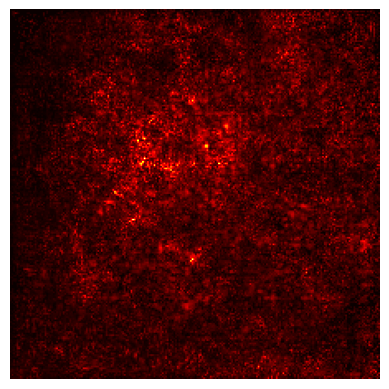

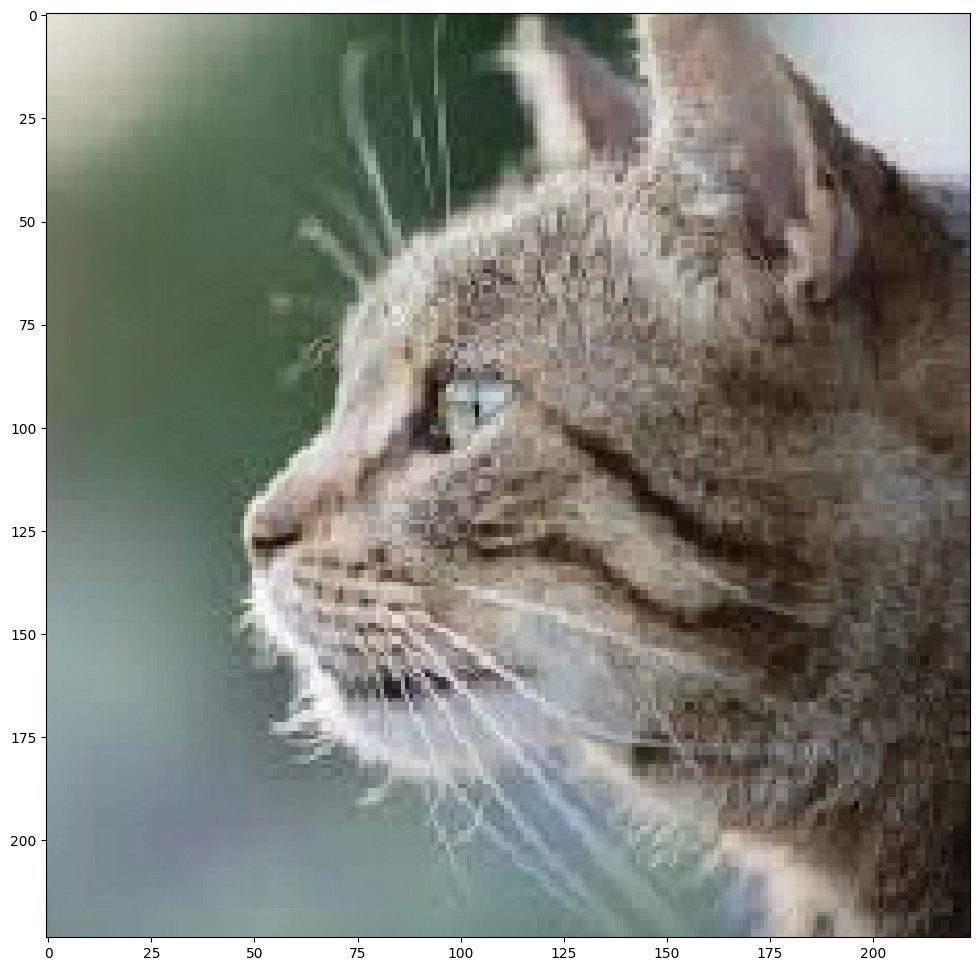

In [ ]:
dream_img = attack(adverse_model, original_img, 10000, 1e-3, 0.9)

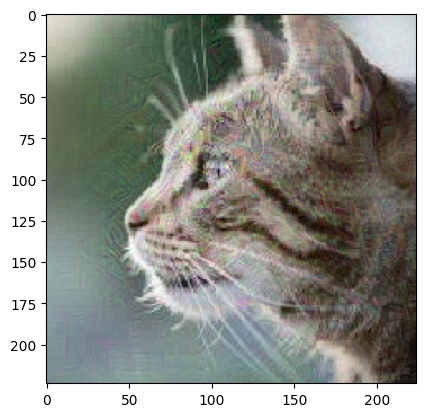

In [ ]:
plt.imshow(np.clip(original_img - 10*(original_img-dream_img), -1, 1)/2+0.5)
plt.show()

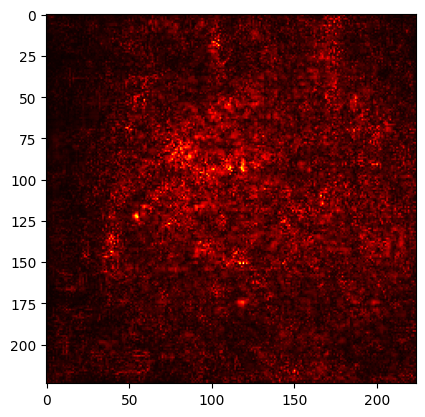

In [ ]:
plt.imshow(abs(original_img-dream_img).mean(axis=-1), cmap='hot')
plt.show()

In [ ]:
new    = base_model.predict(dream_img[None])
old    = base_model.predict(original_img[None])
target = base_model.predict(target_img[None])
# to compare the final prediction value for our newly generated image (to check if the attack has been successful)

In [ ]:
new[0,281], old[0,281], target[0, 281]

(0.00048709253, 0.40596858, 0.00020858177)

In [ ]:
new[0,292], old[0,292], target[0, 292]

(0.99434847, 0.0005832952, 0.68174976)